**Programa No. 1 - Generación de imagenes NDVI usando Python con librería cv2**
En este programa se hará:
1. generacion de imagenes NDVI desde ortomosaico
2. Analisis estadístico de imagen NDVI
3. Guardar imagen en formato .png (mas compatible visualizadores de compu) o formato geoespacial .tif

Intentando cargar imagen NIR desde: /content/drive/MyDrive/Colab Notebooks/MiPrimerMapaNDVI/ReflectanceNIR.tif
Intentando cargar imagen RED desde: /content/drive/MyDrive/Colab Notebooks/MiPrimerMapaNDVI/ReflectanceRED.tif


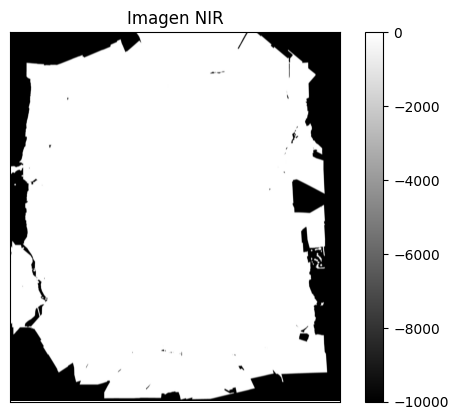

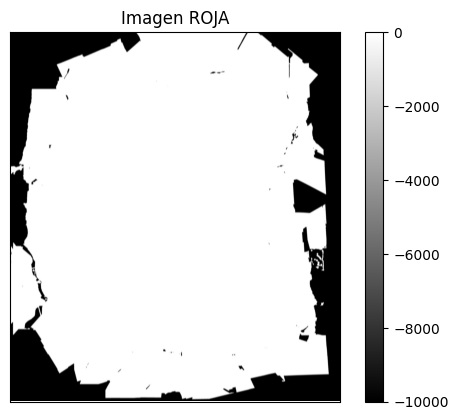

Min NDVI: -1.0
Max NDVI: 1.0


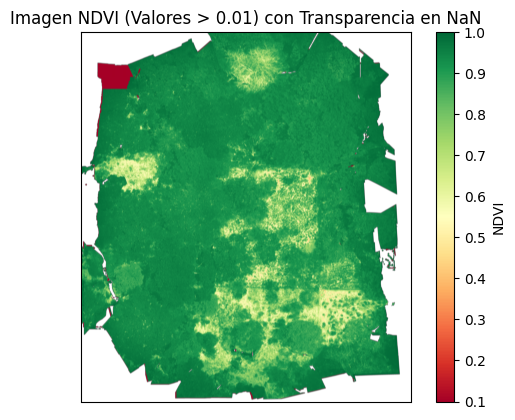

In [ ]:
#PROGRAMA PARA ANALIZAR LOS DATOS PROVENIENTES DE LAS IMAGENES DE LOS DRONES
## IMPORTACION DE LIBRERIAS
from scipy import ndimage
from skimage import io
import os
import cv2
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
from matplotlib import colormaps
from matplotlib import colors
# list(colormaps) # Commented out as it's not directly used in the core logic

# Importar Google Drive y montar
from google.colab import drive
# Asegurarse de que Google Drive esté montado. Si ya está montado, esta línea solo lo confirmará.
# drive.mount('/content/drive') # Asumiendo que drive ya está montado desde una celda anterior

#IMPORTACION DE IMAGENES desde Google Drive
# Actualiza la ruta a tu carpeta específica en Google Drive
drive_image_path = '/content/drive/MyDrive/Colab Notebooks/MiPrimerMapaNDVI'

try:
    # Construir las rutas completas a las imágenes
    nir_image_path = os.path.join(drive_image_path, 'ReflectanceNIR.tif')
    red_image_path = os.path.join(drive_image_path, 'ReflectanceRED.tif')

    print(f"Intentando cargar imagen NIR desde: {nir_image_path}")
    print(f"Intentando cargar imagen RED desde: {red_image_path}")

    # Cargar imágenes usando cv2.imread con la ruta completa
    # Usa -1 para cargar la imagen tal cual, incluyendo el canal alfa si está presente
    imagenNIR = cv2.imread(nir_image_path, -1)
    imagenRED = cv2.imread(red_image_path, -1)
    parametro = 0 # Asumiendo que las imágenes son de un solo canal o usamos el primer canal

    # Verificar si las imágenes se cargaron correctamente
    if imagenNIR is None or imagenRED is None:
        print("Error: No se pudo cargar una o ambas imágenes usando cv2.imread. Por favor, verifica las rutas de los archivos y asegúrate de que las imágenes existan en el directorio especificado y estén en un formato legible por cv2.")
    else:
        # Asegurarse de que las imágenes estén en el formato correcto y calcular el NDVI
        # Si las imágenes son multicanal y quieres un canal específico para el cálculo, ajusta según sea necesario.
        # Asumiendo que las imágenes son en escala de grises o quieres usar un canal específico (por ejemplo, el primer canal, índice 0)
        # Si las imágenes son realmente TIFF de un solo canal, es posible que no necesites la indexación [:,:,parametro].
        # Verifiquemos el número de canales y ajustemos la indexación si es necesario.
        if imagenNIR.ndim == 3 and imagenRED.ndim == 3:
            # Las imágenes son multicanal, usa el canal especificado (parametro)
            nir_channel = imagenNIR[:,:,parametro].astype(float)
            red_channel = imagenRED[:,:,parametro].astype(float)
        elif imagenNIR.ndim == 2 and imagenRED.ndim == 2:
            # Las imágenes son de un solo canal
            nir_channel = imagenNIR.astype(float)
            red_channel = imagenRED.astype(float)
        else:
            print("Error: Las imágenes no están en un formato compatible (un solo canal o multicanal).")
            nir_channel = None # Establecer a None para evitar cálculos posteriores
            red_channel = None # Establecer a None para evitar cálculos posteriores

        # Reemplazar valores de -1000 por NaN en los canales seleccionados
        if nir_channel is not None:
            nir_channel[nir_channel == -1000] = np.nan
        if red_channel is not None:
            red_channel[red_channel == -1000] = np.nan

        if nir_channel is not None and red_channel is not None:
            # Manejar posible división por cero y NaN en el cálculo del NDVI
            # Usamos np.errstate para ignorar advertencias temporales de división por cero o valores inválidos
            with np.errstate(divide='ignore', invalid='ignore'):
                 denominator = nir_channel + red_channel
                 # Reemplazamos 0 en el denominador con NaN para evitar divisiones por cero, luego calculamos NDVI
                 # Ahora también reemplazamos los resultados de NDVI que son exactamente 0 con NaN
                 imagenNDVI = np.where(
                     denominator == 0,
                     np.nan, # Establecer a NaN si el denominador es 0
                     (nir_channel - red_channel) / denominator
                 )

            # Recortar los valores del NDVI al rango [-1, 1]
            imagenNDVI = np.clip(imagenNDVI, -1, 1)

            # Opcional: Reemplazar cualquier valor de NDVI que sea exactamente 0 con NaN después del clip
            # Esto es por si acaso alguna combinación de NIR y RED (no solo 0/0) resulta en un NDVI de 0
            # y queremos tratar esos casos como datos no válidos.
            imagenNDVI = np.where(imagenNDVI == 0, np.nan, imagenNDVI)


            # Mostrar imagen

            # IMAGEN NIR
            plt.xticks([]), plt.yticks([])
            # Si la imagen original era multicanal, mostrar el canal seleccionado
            if imagenNIR.ndim == 3:
                plt.imshow(imagenNIR[:,:,parametro], cmap='gray', interpolation='bicubic')
            else:
                 plt.imshow(imagenNIR, cmap='gray', interpolation='bicubic')
            plt.colorbar()
            plt.title('Imagen NIR') # Añadir títulos para claridad
            plt.show()

            # IMAGEN RED
            plt.xticks([]), plt.yticks([])
            # Si la imagen original era multicanal, mostrar el canal seleccionado
            if imagenRED.ndim == 3:
                 plt.imshow(imagenRED[:,:,parametro], cmap='gray', interpolation='bicubic')
            else:
                plt.imshow(imagenRED, cmap='gray', interpolation='bicubic')
            plt.colorbar()
            plt.title('Imagen ROJA') # Añadir títulos para claridad
            plt.show()

            # IMAGEN NDVI
            print(f"Min NDVI: {np.nanmin(imagenNDVI)}") # Usar f-string para imprimir
            print(f"Max NDVI: {np.nanmax(imagenNDVI)}")
            # np.seterr(divide='ignore', invalid='ignore') # Ya manejado con np.errstate
            plt.xticks([]), plt.yticks([])
            # --- Modificación para transparencia de NaN y ajuste de escala ---
            # Usar la forma recomendada para obtener colormaps
            cmap = plt.colormaps.get_cmap('RdYlGn')
            cmap.set_bad(alpha=0) # Configurar el color para valores 'bad' (NaN) como transparente

            # Ajustar vmin y vmax para enfocar la escala en el rango 0.1 a 1
            plt.imshow(imagenNDVI, cmap=cmap, interpolation='bicubic', vmin=0.1, vmax=1)
            # --- Fin de modificación ---
            plt.colorbar(label='NDVI') # Añadir etiqueta a la barra de color
            plt.title('Imagen NDVI (Valores > 0.01) con Transparencia en NaN') # Actualizar título
            plt.show()

            # Opcional: Guardar la imagen NDVI calculada
            # Nota: Guardar TIFF con cv2 puede ser complejo para datos geoespaciales
            # Considera usar rasterio para guardar si es necesario.


except Exception as e:
    print(f"Ocurrió un error inesperado: {e}")

### Opciones para Guardar la Imagen NDVI

Aquí puedes elegir cómo guardar la imagen NDVI calculada: como un archivo PNG (sin metadatos geoespaciales) o como un archivo GeoTIFF (conservando metadatos).

In [ ]:
# Opción 1: Guardar la imagen NDVI como PNG (sin metadatos geoespaciales)

# Asegurarse de que imagenNDVI existe
if 'imagenNDVI' in locals():
    print("Guardando imagen NDVI como PNG...")

    # --- Modificación para guardar en color y con posible redimensionamiento ---

    # 1. Aplicar colormap (usando el mismo que para la visualización)
    # Usar la forma recomendada para obtener colormaps
    cmap = plt.colormaps.get_cmap('RdYlGn')
    # Normalize the NDVI values to the range [0, 1] for the colormap
    # We'll use vmin=0, vmax=1 as in the display, mapping NaN to a specific color or alpha
    # For saving as PNG, we might need to convert NaN to a displayable color or handle alpha channel.
    # Let's normalize to [0, 1] ignoring NaN for now, and handle NaN later if needed for alpha.
    ndvi_normalized = np.interp(imagenNDVI, (-1, 1), (0, 1)) # Normalize from [-1, 1] to [0, 1]

    # Apply the colormap to the normalized data
    # This will create an RGBA image
    ndvi_colored = cmap(ndvi_normalized)

    # Handle NaN values by setting their alpha to 0 (transparent)
    ndvi_colored[np.isnan(imagenNDVI), 3] = 0 # Set alpha channel to 0 for NaN

    # Convert the RGBA image to uint8 (0-255)
    # Multiply by 255 and convert to integer type
    ndvi_uint8_rgba = (ndvi_colored * 255).astype(np.uint8)

    # If you want to save without an alpha channel, convert RGBA to RGB by dropping the alpha channel
    ndvi_uint8_rgb = ndvi_uint8_rgba[:,:,:3]

    # 2. Opcional: Redimensionar la imagen para una mejor resolución
    # Define a scaling factor (e.g., 2 for double resolution)
    # scaling_factor = 2
    # new_width = int(ndvi_uint8_rgb.shape[1] * scaling_factor)
    # new_height = int(ndvi_uint8_rgb.shape[0] * scaling_factor)
    # resized_ndvi_rgb = cv2.resize(ndvi_uint8_rgb, (new_width, new_height), interpolation=cv2.INTER_CUBIC)
    # image_to_save = resized_ndvi_rgb
    # print(f"Resized image to {new_width}x{new_height}")


    # If not resizing, use the original colored image (RGB version for saving with cv2)
    image_to_save = ndvi_uint8_rgb # Use the RGB version

    # --- Fin de modificación ---


    # Definir la ruta de guardado en Google Drive
    output_png_path = '/content/drive/MyDrive/Colab Notebooks/MiPrimerMapaNDVI/ndvi_calculado_color.png' # Changed filename

    try:
        # Guardar la imagen usando cv2.imwrite
        # cv2.imwrite can save color images (RGB)
        success = cv2.imwrite(output_png_path, image_to_save)

        if success:
            print(f"Imagen NDVI (PNG a color) guardada exitosamente en: {output_png_path}")
        else:
            print(f"Error al guardar la imagen NDVI (PNG a color) en: {output_png_path}. Verifica la ruta y permisos.")

    except Exception as e:
        print(f"Ocurrió un error al intentar guardar la imagen PNG a color: {e}")

else:
    print("Error: La variable 'imagenNDVI' no se encontró. Por favor, asegúrate de haber ejecutado primero la celda que calcula el NDVI.")

Guardando imagen NDVI como PNG...
Imagen NDVI (PNG a color) guardada exitosamente en: /content/drive/MyDrive/Colab Notebooks/MiPrimerMapaNDVI/ndvi_calculado_color.png


In [ ]:
# Opción 2: Guardar la imagen NDVI como GeoTIFF (conservando metadatos)

# Asegurarse de que imagenNDVI y profile existen (requiere haber cargado imágenes con rasterio antes)
if 'imagenNDVI' in locals() and 'profile' in locals():
    print("Guardando imagen NDVI como GeoTIFF...")
    # Asegurarse de que el array NDVI sea de punto flotante para GeoTIFF
    ndvi_float32 = imagenNDVI.astype(rasterio.float32)

    # Actualizar el perfil para reflejar el tipo de dato de salida y el número de bandas (1 para NDVI)
    output_profile = profile.copy() # Crear una copia para no modificar el perfil original
    output_profile.update(dtype=rasterio.float32, count=1)

    # Definir la ruta de guardado en Google Drive
    output_geotiff_path = '/content/drive/MyDrive/Colab Notebooks/MiPrimerMapaNDVI/ndvi_calculado.tif'

    try:
        # Guardar la imagen usando rasterio
        with rasterio.open(output_geotiff_path, 'w', **output_profile) as dst:
            dst.write(ndvi_float32, 1) # Escribir la imagen NDVI en la primera banda

        print(f"Imagen NDVI (GeoTIFF) guardada exitosamente en: {output_geotiff_path}")

    except Exception as e:
        print(f"Ocurrió un error al intentar guardar la imagen GeoTIFF: {e}")

else:
    print("Error: Las variables 'imagenNDVI' y/o 'profile' no se encontraron. Por favor, asegúrate de haber calculado el NDVI y cargado las imágenes con rasterio previamente.")

Guardando imagen NDVI como GeoTIFF...
Imagen NDVI (GeoTIFF) guardada exitosamente en: /content/drive/MyDrive/Colab Notebooks/MiPrimerMapaNDVI/ndvi_calculado.tif


Analsis estadístico de NDVI

Estadísticas del NDVI:
Media: 0.8814504375684051
Mediana: 0.9288970361425756
Desviación estándar: 0.2122798268753734
Mínimo: -1.0
Máximo: 1.0


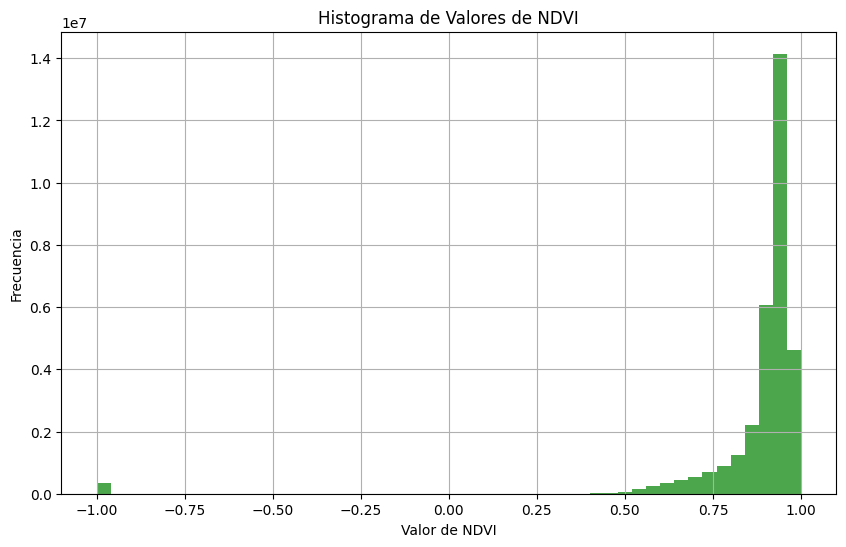

In [ ]:
# Análisis estadístico del NDVI
print("Estadísticas del NDVI:")
print(f"Media: {np.nanmean(imagenNDVI)}")
print(f"Mediana: {np.nanmedian(imagenNDVI)}")
print(f"Desviación estándar: {np.nanstd(imagenNDVI)}")
print(f"Mínimo: {np.nanmin(imagenNDVI)}")
print(f"Máximo: {np.nanmax(imagenNDVI)}")

# Histograma del NDVI
plt.figure(figsize=(10, 6))
plt.hist(imagenNDVI[~np.isnan(imagenNDVI)], bins=50, color='green', alpha=0.7)
plt.title('Histograma de Valores de NDVI')
plt.xlabel('Valor de NDVI')
plt.ylabel('Frecuencia')
plt.grid(True)
plt.show()

**Programa No. 2** - Generación de imagenes NDVI usando Python con librería rasterio

En este programa se hará:

1. generacion de imagenes NDVI desde ortomosaico usando rasterio
2. Analisis estadístico de imagen NDVI
3. Guardar imagen en formato .png (mas compatible visualizadores de compu) o formato geoespacial .tif

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


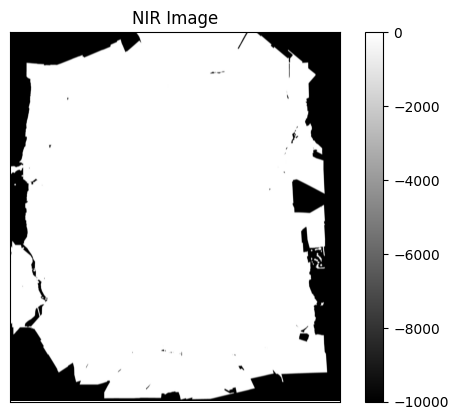

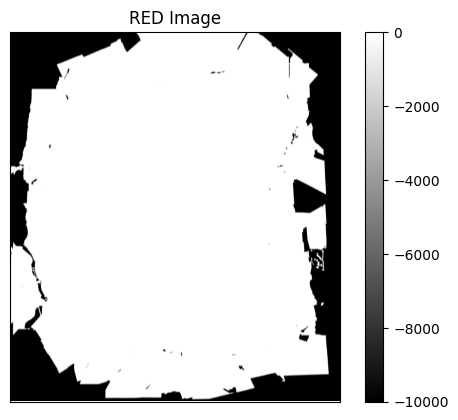

Min NDVI: -1.0
Max NDVI: 1.0


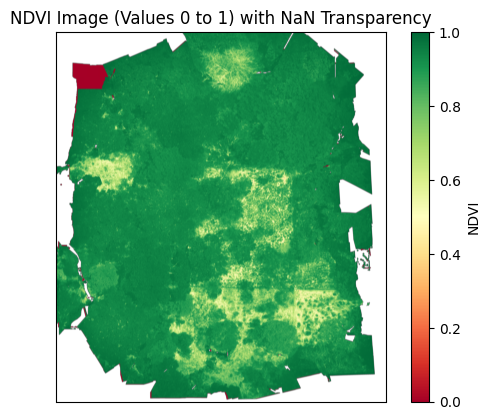

In [ ]:
#PROGRAMA PARA ANALIZAR LOS DATOS PROVENIENTES DE LAS IMAGENES DE LOS DRONES
## IMPORTACION DE LIBRERIAS
from scipy import ndimage
from skimage import io
import os
import cv2
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
from matplotlib import colormaps
from matplotlib import colors
import rasterio # Import rasterio for reading TIFF files

# List available colormaps
list(colormaps)

# Import Google Drive and mount
from google.colab import drive
# Ensure Google Drive is mounted. If it's already mounted, this line will just confirm.
drive.mount('/content/drive')

#IMPORTACION DE IMAGENES from Google Drive
# Update the path to your specific folder in Google Drive
# This path is based on your previous input
drive_image_path = '/content/drive/MyDrive/Colab Notebooks/MiPrimerMapaNDVI'

try:
    # Construct the full paths to the images
    nir_image_path = os.path.join(drive_image_path, 'ReflectanceNIR.tif')
    red_image_path = os.path.join(drive_image_path, 'ReflectanceRED.tif')

    # Check if the files exist at the specified path
    if not os.path.exists(nir_image_path):
        print(f"Error: NIR image not found at {nir_image_path}")
    if not os.path.exists(red_image_path):
        print(f"Error: RED image not found at {red_image_path}")

    # Load images using rasterio
    # Make sure the files exist before attempting to open with rasterio
    if os.path.exists(nir_image_path) and os.path.exists(red_image_path):
        with rasterio.open(nir_image_path) as nir_src:
            imagenNIR = nir_src.read(1).astype('float32')
            profile = nir_src.profile # Get profile for saving later

        with rasterio.open(red_image_path) as red_src:
            imagenRED = red_src.read(1).astype('float32')

        # Calculate NDVI
        # Handle potential division by zero by setting to NaN if the sum of nir and red is zero
        imagenNDVI = np.where(
            (imagenNIR + imagenRED) == 0,
            np.nan, # Set to NaN if denominator is 0
            (imagenNIR - imagenRED) / (imagenNIR + imagenRED)
        )

        # Optional: Replace any NDVI values that are exactly 0 with NaN after the initial calculation
        # This is in case some combination of NIR and RED results in exactly 0 NDVI
        imagenNDVI = np.where(imagenNDVI == 0, np.nan, imagenNDVI)

        # Recortar los valores del NDVI al rango [-1, 1]
        imagenNDVI = np.clip(imagenNDVI, -1, 1)


        # Mostrar imagen

        # IMAGEN NIR
        plt.xticks([]), plt.yticks([])
        plt.imshow(imagenNIR, cmap='gray', interpolation='bicubic')
        plt.colorbar()
        plt.title('NIR Image') # Add titles for clarity
        plt.show()

        # IMAGEN RED
        plt.xticks([]), plt.yticks([])
        plt.imshow(imagenRED, cmap='gray', interpolation='bicubic')
        plt.colorbar()
        plt.title('RED Image') # Add titles for clarity
        plt.show()

        # IMAGEN NDVI
        print(f"Min NDVI: {np.nanmin(imagenNDVI)}") # Use f-string for printing
        print(f"Max NDVI: {np.nanmax(imagenNDVI)}")
        np.seterr(divide='ignore', invalid='ignore')
        plt.xticks([]), plt.yticks([])
        # --- Modificación para transparencia de NaN y ajuste de escala (0 a 1) ---
        # Usar la forma recomendada para obtener colormaps
        cmap = plt.colormaps.get_cmap('RdYlGn')
        cmap.set_bad(alpha=0) # Configurar el color para valores 'bad' (NaN) como transparente

        # Ajustar vmin y vmax para enfocar la escala en el rango 0 a 1
        plt.imshow(imagenNDVI, cmap=cmap, interpolation='bicubic', vmin=0, vmax=1)
        # --- Fin de modificación ---
        plt.colorbar(label='NDVI') # Añadir etiqueta a la barra de color
        plt.title('NDVI Image (Values 0 to 1) with NaN Transparency') # Actualizar título
        plt.show()

        # Optional: Save the calculated NDVI image
        # profile.update(dtype=rasterio.float32, count=1)
        # with rasterio.open(os.path.join(drive_image_path, 'ndvi_calculated.tif'), 'w', **profile) as dst:
        #     dst.write(imagenNDVI, 1)

    else:
        print("Image files not found at the specified Google Drive path.")


except FileNotFoundError:
    print(f"Error: Make sure the path '{drive_image_path}' is correct and the images exist in that folder in your Google Drive.")
except rasterio.errors.RasterioIOError as e:
    print(f"Error loading images: {e}")
    print(f"Please make sure 'ReflectanceNIR.tif' and 'ReflectanceRED.tif' exist in '{drive_image_path}'.")
except Exception as e:
    print(f"An unexpected error occurred: {e}")

### Análisis Estadístico y Guardado de Imagen NDVI (Programa No. 2 - con rasterio)

Aquí puedes realizar el análisis estadístico y elegir cómo guardar la imagen NDVI calculada usando `rasterio`.

Estadísticas del NDVI:
Media: 0.8814489841461182
Mediana: 0.9288970232009888
Desviación estándar: 0.21228839457035065
Mínimo: -1.0001670122146606
Máximo: 1.0000234842300415


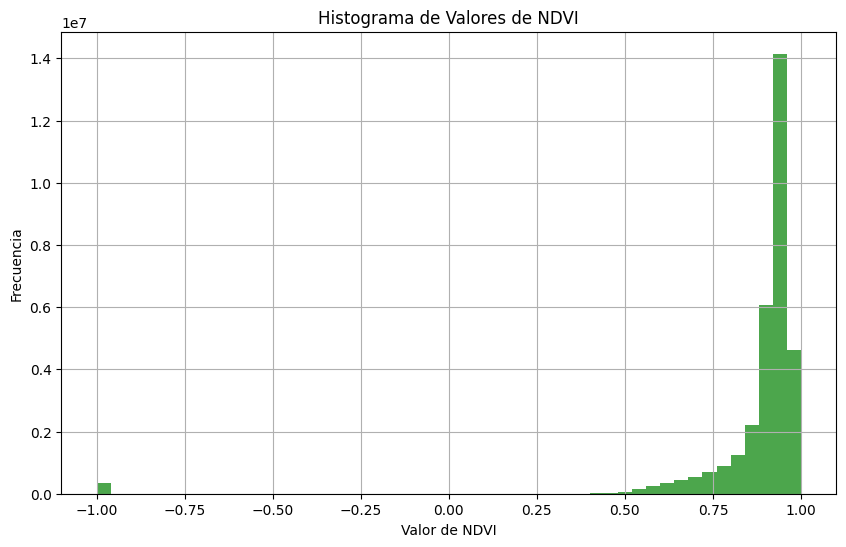

In [ ]:
# Análisis estadístico del NDVI (Programa No. 2)

# Asegurarse de que imagenNDVI existe
if 'imagenNDVI' in locals():
    print("Estadísticas del NDVI:")
    print(f"Media: {np.nanmean(imagenNDVI)}")
    print(f"Mediana: {np.nanmedian(imagenNDVI)}")
    print(f"Desviación estándar: {np.nanstd(imagenNDVI)}")
    print(f"Mínimo: {np.nanmin(imagenNDVI)}")
    print(f"Máximo: {np.nanmax(imagenNDVI)}")

    # Histograma del NDVI
    plt.figure(figsize=(10, 6))
    plt.hist(imagenNDVI[~np.isnan(imagenNDVI)], bins=50, color='green', alpha=0.7)
    plt.title('Histograma de Valores de NDVI')
    plt.xlabel('Valor de NDVI')
    plt.ylabel('Frecuencia')
    plt.grid(True)
    plt.show()
else:
    print("Error: La variable 'imagenNDVI' no se encontró. Por favor, asegúrate de haber ejecutado primero la celda que calcula el NDVI en el Programa No. 2.")

In [ ]:
# Opción de Guardado 1 (Programa No. 2): Guardar la imagen NDVI como PNG (sin metadatos geoespaciales)

# Asegurarse de que imagenNDVI existe
if 'imagenNDVI' in locals():
    print("Guardando imagen NDVI como PNG...")

    # --- Modificación para guardar en color ---

    # 1. Aplicar colormap (usando el mismo que para la visualización)
    # Usar la forma recomendada para obtener colormaps
    cmap = plt.colormaps.get_cmap('RdYlGn')
    # Normalize the NDVI values to the range [0, 1] for the colormap
    # We'll use vmin=0, vmax=1 as in the display, mapping NaN to a specific color or alpha
    # Normalize from [-1, 1] to [0, 1] for the colormap
    ndvi_normalized = np.interp(imagenNDVI, (-1, 1), (0, 1))

    # Apply the colormap to the normalized data
    # This will create an RGBA image
    ndvi_colored = cmap(ndvi_normalized)

    # Handle NaN values by setting their alpha to 0 (transparent)
    ndvi_colored[np.isnan(imagenNDVI), 3] = 0 # Set alpha channel to 0 for NaN

    # Convert the RGBA image to uint8 (0-255)
    # Multiply by 255 and convert to integer type
    ndvi_uint8_rgba = (ndvi_colored * 255).astype(np.uint8)

    # Convert RGBA to RGB for saving with cv2 (cv2.imwrite typically saves RGB)
    image_to_save = ndvi_uint8_rgba[:,:,:3]

    # --- Fin de modificación ---


    # Definir la ruta de guardado en Google Drive
    # Puedes cambiar el nombre del archivo si lo deseas
    output_png_path = os.path.join(drive_image_path, 'ndvi_calculado_programa2_color.png') # Changed filename to indicate color

    try:
        # Guardar la imagen usando cv2.imwrite
        # cv2.imwrite can save color images (RGB)
        success = cv2.imwrite(output_png_path, image_to_save)

        if success:
            print(f"Imagen NDVI (PNG a color) guardada exitosamente en: {output_png_path}")
        else:
            print(f"Error al guardar la imagen NDVI (PNG a color) en: {output_png_path}. Verifica la ruta y permisos.")

    except Exception as e:
        print(f"Ocurrió un error al intentar guardar la imagen PNG a color: {e}")

else:
    print("Error: La variable 'imagenNDVI' no se encontró. Por favor, asegúrate de haber ejecutado primero la celda que calcula el NDVI en el Programa No. 2.")

Guardando imagen NDVI como PNG...
Imagen NDVI (PNG a color) guardada exitosamente en: /content/drive/MyDrive/Colab Notebooks/MiPrimerMapaNDVI/ndvi_calculado_programa2_color.png


In [ ]:
# Opción de Guardado 2 (Programa No. 2): Guardar la imagen NDVI como GeoTIFF (conservando metadatos)

# Asegurarse de que imagenNDVI y profile existen (requiere haber cargado imágenes con rasterio antes)
if 'imagenNDVI' in locals() and 'profile' in locals():
    print("Guardando imagen NDVI como GeoTIFF...")
    # Asegurarse de que el array NDVI sea de punto flotante para GeoTIFF
    ndvi_float32 = imagenNDVI.astype(rasterio.float32)

    # Actualizar el perfil para reflejar el tipo de dato de salida y el número de bandas (1 para NDVI)
    output_profile = profile.copy() # Crear una copia para no modificar el perfil original
    output_profile.update(dtype=rasterio.float32, count=1)

    # Definir la ruta de guardado en Google Drive
    output_geotiff_path = os.path.join(drive_image_path, 'ndvi_calculated_programa2.tif') # Usar una ruta diferente si es necesario

    try:
        # Guardar la imagen usando rasterio
        with rasterio.open(output_geotiff_path, 'w', **output_profile) as dst:
            dst.write(ndvi_float32, 1) # Escribir la imagen NDVI en la primera banda

        print(f"Imagen NDVI (GeoTIFF) guardada exitosamente en: {output_geotiff_path}")

    except Exception as e:
        print(f"Ocurrió un error al intentar guardar la imagen GeoTIFF: {e}")

else:
    print("Error: Las variables 'imagenNDVI' y/o 'profile' no se encontraron. Por favor, asegúrate de haber calculado el NDVI y cargado las imágenes con rasterio previamente en el Programa No. 2.")

Guardando imagen NDVI como GeoTIFF...
Imagen NDVI (GeoTIFF) guardada exitosamente en: /content/drive/MyDrive/Colab Notebooks/MiPrimerMapaNDVI/ndvi_calculated_programa2.tif


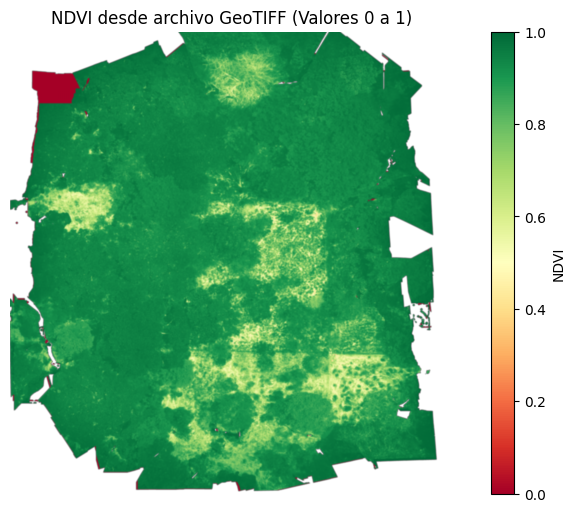

Estadísticas del NDVI cargado:
Media: 0.8814891576766968
Mediana: 0.9288962483406067
Desviación estándar: 0.21210485696792603
Mínimo: -1.0
Máximo: 1.0


In [ ]:
import rasterio
import numpy as np
import matplotlib.pyplot as plt
import os

# Assuming the file 'ndvi_calculado.tif' is in the Google Drive folder used previously
drive_image_path = '/content/drive/MyDrive/Colab Notebooks/MiPrimerMapaNDVI'
ndvi_file_path = os.path.join(drive_image_path, 'ndvi_calculado.tif')

# Check if the file exists
if not os.path.exists(ndvi_file_path):
    print(f"Error: NDVI file not found at {ndvi_file_path}")
else:
    try:
        with rasterio.open(ndvi_file_path) as src:
            # Read the single NDVI band (band 1)
            ndvi = src.read(1)

        # Visualizar
        plt.figure(figsize=(10, 6))
        # Use a colormap suitable for NDVI, and set vmin/vmax to the typical range
        # Handle NaN values for transparency
        cmap = plt.colormaps.get_cmap('RdYlGn')
        cmap.set_bad(alpha=0) # Make NaN values transparent

        # Adjust vmin and vmax to focus the scale on the range 0 to 1
        plt.imshow(ndvi, cmap=cmap, interpolation='bicubic', vmin=0, vmax=1)
        plt.colorbar(label='NDVI')
        plt.title('NDVI desde archivo GeoTIFF (Valores 0 a 1)') # Update title
        plt.axis('off')
        plt.show()

        # Optional: Perform statistical analysis on the loaded NDVI data
        print("Estadísticas del NDVI cargado:")
        print(f"Media: {np.nanmean(ndvi)}")
        print(f"Mediana: {np.nanmedian(ndvi)}")
        print(f"Desviación estándar: {np.nanstd(ndvi)}")
        print(f"Mínimo: {np.nanmin(ndvi)}")
        print(f"Máximo: {np.nanmax(ndvi)}")


    except rasterio.errors.RasterioIOError as e:
        print(f"Error loading NDVI file: {e}")
    except Exception as e:
        print(f"An unexpected error occurred: {e}")

In [ ]:
# Análisis estadístico del array NDVI cargado del archivo GeoTIFF

# Asegurarse de que el array ndvi existe
if 'ndvi' in locals():
    print("Estadísticas del array NDVI cargado:")
    print(f"Media: {np.nanmean(ndvi)}")
    print(f"Mediana: {np.nanmedian(ndvi)}")
    print(f"Desviación estándar: {np.nanstd(ndvi)}")
    print(f"Mínimo: {np.nanmin(ndvi)}")
    print(f"Máximo: {np.nanmax(ndvi)}")
else:
    print("Error: La variable 'ndvi' no se encontró. Por favor, asegúrate de haber ejecutado primero la celda que carga el archivo GeoTIFF de NDVI.")

Estadísticas del array NDVI cargado:
Media: 0.8814891576766968
Mediana: 0.9288962483406067
Desviación estándar: 0.21210485696792603
Mínimo: -1.0
Máximo: 1.0


In [ ]:
# Histograma del array NDVI cargado del archivo GeoTIFF

# Asegurarse de que el array ndvi existe
if 'ndvi' in locals():
    plt.figure(figsize=(10, 6))
    # Excluir valores NaN para el histograma
    plt.hist(ndvi[~np.isnan(ndvi)], bins=50, color='green', alpha=0.0) # Made alpha 0 for now, adjust if needed for visibility
    plt.title('Histograma de Valores de NDVI (desde GeoTIFF)')
    plt.xlabel('Valor de NDVI')
    plt.ylabel('Frecuencia')
    plt.grid(True)
    plt.show()
else:
    print("Error: La variable 'ndvi' no se encontró. Por favor, asegúrate de haber ejecutado primero la celda que carga el archivo GeoTIFF de NDVI.")

**Conversor de TIF a PNG**

In [81]:
import rasterio
import numpy as np
import cv2
import os
import matplotlib.pyplot as plt # Import matplotlib for colormaps

# Assuming the GeoTIFF file is in the Google Drive folder used previously
drive_image_path = '/content/drive/MyDrive/Colab Notebooks/MiPrimerMapaNDVI'
geotiff_file_path = os.path.join(drive_image_path, 'Copia de NDVI_Sentinel2.tif') # Or 'ndvi_calculated_programa2.tif'

# Define the output PNG file path
output_png_path = os.path.join(drive_image_path, 'ndvi_Sentinel2_converted_from_geotiff.png')

# Check if the GeoTIFF file exists
if not os.path.exists(geotiff_file_path):
    print(f"Error: GeoTIFF file not found at {geotiff_file_path}")
else:
    try:
        with rasterio.open(geotiff_file_path) as src:
            # Read the single NDVI band (band 1)
            ndvi = src.read(1)

        # --- Convert NDVI to a color image for PNG saving ---

        # Handle NaN values by setting them to a value outside the colormap range
        # or by using a masked array. For simplicity and direct colormap application,
        # we'll handle NaN during colormap application.

        # Use a colormap suitable for NDVI (e.g., RdYlGn)
        cmap = plt.colormaps.get_cmap('RdYlGn')

        # Normalize the NDVI values to the range [0, 1] for the colormap
        # Use np.interp to map the NDVI range [-1, 1] to [0, 1]
        ndvi_normalized = np.interp(ndvi, (-1, 1), (0, 1))

        # Apply the colormap to the normalized data
        # This will create an RGBA image (including an alpha channel)
        ndvi_colored_rgba = cmap(ndvi_normalized)

        # Handle NaN values by setting their alpha to 0 (transparent)
        # Ensure ndvi_colored_rgba is writable before modifying
        ndvi_colored_rgba = ndvi_colored_rgba.copy()
        ndvi_colored_rgba[np.isnan(ndvi), 3] = 0 # Set alpha channel to 0 for NaN

        # Convert the RGBA image to uint8 (0-255)
        # Multiply by 255 and convert to integer type
        ndvi_uint8_rgba = (ndvi_colored_rgba * 255).astype(np.uint8)

        # For saving with cv2.imwrite, we typically save RGB images.
        # If you want to include transparency, you might need to save as PNG with an alpha channel,
        # which cv2.imwrite supports for some formats.
        # Let's keep the alpha channel for potential transparency in the PNG.
        image_to_save = ndvi_uint8_rgba

        # --- End of conversion ---


        # Save the image using cv2.imwrite
        # cv2.imwrite supports saving PNG with alpha channel (RGBA)
        success = cv2.imwrite(output_png_path, image_to_save)

        if success:
            print(f"Imagen NDVI convertida y guardada como PNG en: {output_png_path}")
        else:
            print(f"Error al guardar la imagen PNG en: {output_png_path}. Verifica la ruta y permisos.")

    except rasterio.errors.RasterioIOError as e:
        print(f"Error loading NDVI file: {e}")
    except Exception as e:
        print(f"An unexpected error occurred: {e}")

Imagen NDVI convertida y guardada como PNG en: /content/drive/MyDrive/Colab Notebooks/MiPrimerMapaNDVI/ndvi_Sentinel2_converted_from_geotiff.png


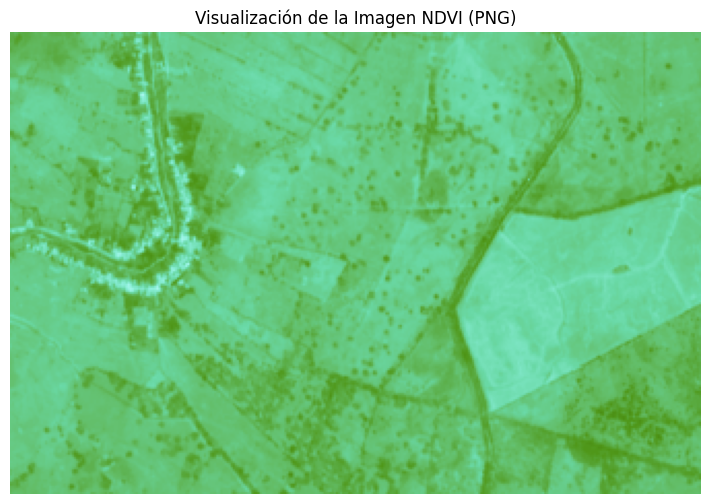

In [82]:
import cv2
import matplotlib.pyplot as plt
import os

# Assuming the PNG file is in the Google Drive folder used previously
drive_image_path = '/content/drive/MyDrive/Colab Notebooks/MiPrimerMapaNDVI'
png_file_path = os.path.join(drive_image_path, 'ndvi_Sentinel2_converted_from_geotiff.png')

# Check if the PNG file exists
if not os.path.exists(png_file_path):
    print(f"Error: PNG file not found at {png_file_path}")
else:
    try:
        # Load the PNG image using cv2.imread
        # Use -1 to load the image as is (including alpha channel if present)
        png_image = cv2.imread(png_file_path, -1)

        # Check if the image was loaded successfully
        if png_image is None:
            print(f"Error: Could not load the image from {png_file_path}. Please check the file path and format.")
        else:
            # Convert the image from BGR (cv2 default) to RGB for matplotlib display
            # If the image has an alpha channel (4 channels), convert BGR to RGBA
            if png_image.shape[-1] == 4:
                png_image_display = cv2.cvtColor(png_image, cv2.COLOR_BGRA2RGBA)
            # If the image is color (3 channels), convert BGR to RGB
            elif png_image.shape[-1] == 3:
                png_image_display = cv2.cvtColor(png_image, cv2.COLOR_BGR2RGB)
            # If the image is grayscale (2 channels - data + alpha, or 1 channel), display as is
            else:
                png_image_display = png_image # Assuming 1 channel is grayscale, 2 channels is grayscale + alpha

            # Display the image
            plt.figure(figsize=(10, 6))
            plt.imshow(png_image_display)
            plt.title('Visualización de la Imagen NDVI (PNG)')
            plt.axis('off') # Hide axes
            plt.show()

    except Exception as e:
        print(f"An unexpected error occurred: {e}")